# Hacking Score

We explore how different scores affect the results. We then will see what information leakage will do.

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import alphapept.io

file_path = 'thermo_HeLa.ms_data.hdf'
from alphapept.score import get_ML_features, filter_with_ML, filter_with_x_tandem, cut_global_fdr, train_RF

ms_file = alphapept.io.MS_Data_File(file_path)

df = ms_file.read(dataset_name='second_search')
df = get_ML_features(df)

INFO:root:Cupy is not available


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

clf_cols = ['charge', 'db_idx', 'delta_m', 'delta_m_ppm', 'feature_idx',
       'fragment_ion_idx', 'fragments_int_ratio', 'fragments_int_sum',
       'fragments_matched_int_ratio', 'fragments_matched_int_sum', 'fwhm',
       'hits', 'hits_b', 'hits_b-H2O', 'hits_b-NH3', 'hits_y', 'hits_y-H2O',
       'hits_y-NH3', 'mass', 'mass_db', 'ms1_int_max_apex', 'ms1_int_max_area',
       'ms1_int_sum_apex', 'ms1_int_sum_area', 'mz', 'n_fragments_matched',
       'n_frags_db', 'prec_offset', 'prec_offset_ppm', 'prec_offset_raw',
       'prec_offset_raw_ppm', 'query_idx', 'raw_idx', 'rt',
       'rt_apex', 'rt_end', 'rt_start', 'scan_no',
       'delta_m_ppm_abs', 'n_AA',
       'fragments_matched_n_ratio', 'n_missed', 'n_internal', 'x_tandem',
       'generic_score']

X = df[clf_cols]

clf = RandomForestClassifier(random_state=0, n_jobs=-1)

y = df['decoy'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

<Figure size 504x504 with 0 Axes>

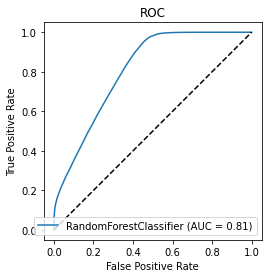

In [5]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(7,7))
RocCurveDisplay.from_estimator(clf, X_test, y_test)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.show()

In [6]:
y_hat = clf.predict(X)

--- ML ---


INFO:root:59,486 target (5,948 decoy) of 85,308 PSMs. FDR 0.099990 for a cutoff of 20.77 (set FDR was 0.1).
INFO:root:Training & cross-validation on 12,754 targets and 12,754 decoys
INFO:root:The best parameters selected by 5-fold cross-validation were {'clf__max_depth': 25, 'clf__max_leaf_nodes': 150}
INFO:root:The train accuracy was 0.972
INFO:root:Testing on 51,016 targets and 51,016 decoys
INFO:root:The test accuracy was 0.966
INFO:root:ML Top features
INFO:root:1	decoy_prediction               0.3079
INFO:root:2	generic_score                  0.1549
INFO:root:3	hits_y                         0.1467
INFO:root:4	x_tandem                       0.0895
INFO:root:5	hits                           0.0869
INFO:root:6	fragments_matched_n_ratio      0.0301
INFO:root:7	n_fragments_matched            0.0291
INFO:root:8	fragments_matched_int_ratio    0.0238
INFO:root:9	delta_m_ppm_abs                0.0179
INFO:root:10	fragments_matched_int_sum      0.0164
INFO:root:11	n_missed                 

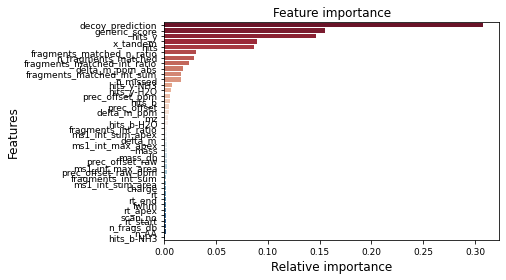

INFO:root:Filter df with x_tandem score
/Users/flq567/miniconda3/envs/alphapept/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
INFO:root:Global FDR on precursor
INFO:root:57,825 target (578 decoy) of 84,736 PSMs. FDR 0.009996 for a cutoff of 0.70 (set FDR was 0.01).


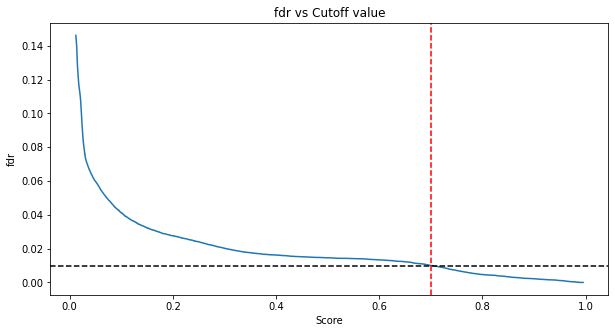

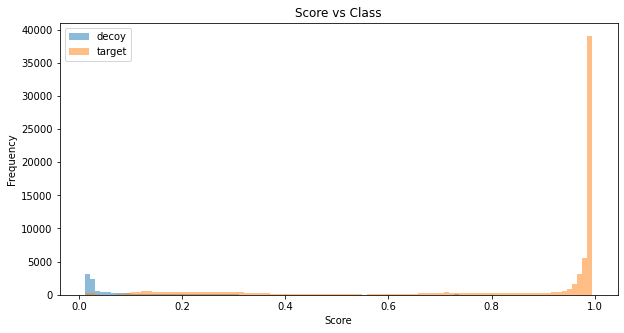

INFO:root:Global FDR cutoff at 0.701.


In [7]:
print('--- ML ---')

ml_fake = df.copy()
ml_fake['decoy_prediction'] = y_hat

cv, features = train_RF(ml_fake, plot=True)
ml_fake = filter_with_ML(ml_fake, cv, features = features)

ml_fake = cut_global_fdr(ml_fake, analyte_level='precursor',  plot=True)
